In [1]:
# Import necessary libraries
import os
import sys
import asyncio
from typing import Dict, List, Any
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Import project-specific modules
from models.message import Message
from models.product import Product
from services.weaviate_service import WeaviateService
from services.openai_service import OpenAIService
from services.query_processor import QueryProcessor
from config import Config

# Load configuration
config = Config()

# Initialize services
weaviate_service = None
openai_service = None
query_processor = None


async def initialize_services():
    global weaviate_service, openai_service, query_processor
    weaviate_service = WeaviateService()
    await weaviate_service.initialize_weaviate(config.OPENAI_API_KEY, config.WEAVIATE_URL, config.RESET_WEAVIATE)
    openai_service = OpenAIService(config.OPENAI_API_KEY, config)
    query_processor = QueryProcessor(openai_service=openai_service)


# Run initialization
await initialize_services()

INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:root: Weaviate schema is valid: True
INFO:root: Weaviate schema info: Weaviate Schema Information

Class: Product (Entries: 768)
Properties:
  - Name: name, Type: text, Description: The name of the product.
  - Name: ids, Type: text, Description: ids of the products
  - Name: manufacturer, Type: text, Description: The manufacturer of the product.
  - Name: form_factor, Type: text, Description: The form of the product.
  - Name: processor, Type: text, Description: The processor of the product.
  - Name: core_coun

===:> Initializing Weaviate


In [10]:
# Helper functions
def get_unique_products(products):
    unique_products = {}
    for prod in products:
        if prod["name"] not in unique_products:
            unique_products[prod["name"]] = Product(**prod)
    return list(unique_products.values())


async def display_search_results(query: str, features: List[str], limit: int = 5):
    print(f"Searching for: {query}")
    results = await weaviate_service.search_products(query, limit=limit)
    print("-" * 80)
    for result in results:
        for feature in features:
            print(f"{str(feature).capitalize()}: {result[feature]}")
    print("-" * 80)
    return results


def compare_products(extended_products: List[str], original_products: List[str]) -> None:
    max_length = max(len(extended_products), len(original_products))
    comparison = pd.DataFrame(
        {
            "Original Products": pd.Series(original_products + [""] * (max_length - len(original_products))),
            "Extended Products": pd.Series(extended_products + [""] * (max_length - len(extended_products))),
        }
    )
    display(HTML(comparison.to_html(index=False)))


def generate_semantic_search_queries(comprehensive_result: Dict[str, Any]) -> List[str]:
    expanded_queries = comprehensive_result["expanded_queries"]
    search_params = comprehensive_result["search_params"]
    extracted_attributes = comprehensive_result["extracted_attributes"]

    queries = expanded_queries.copy()
    search_param_query = ", ".join([f"{key}: {', '.join(value)}" for key, value in search_params.items()])
    queries.append(search_param_query)
    extracted_attributes_query = ", ".join([f"{key}: {value}" for key, value in extracted_attributes.items()])
    queries.append(extracted_attributes_query)

    # we also want to return list of attributes that were extracted
    attributes = list(extracted_attributes.keys())

    return queries, attributes


In [20]:
# Experiment class
class Experiment:
    def __init__(self, query: str, chat_history: List[Dict[str, str]] = None):
        self.query = query
        self.chat_history = chat_history or []
        self.results = {}

    async def run(self):
        # Original search
        self.results["original"] = await display_search_results(self.query, ["name"], 10)
        self.results["unique_original"] = get_unique_products(self.results["original"])

        # Comprehensive query processing
        comprehensive_result, input_tokens, output_tokens = await query_processor.process_query_comprehensive3(
            self.query, self.chat_history
        )
        self.results["comprehensive"] = comprehensive_result
        print(f"Input tokens: {input_tokens}, Output tokens: {output_tokens}")
        pprint(comprehensive_result)

        # Generate and run semantic search queries
        queries, attributes = generate_semantic_search_queries(comprehensive_result)
        print(f"Generated queries: {queries}")
        print(f"Extracted attributes: {attributes}")
        self.results["extended"] = []
        for query in queries:
            products = await display_search_results(query, ["name"])
            self.results["extended"].extend(products)
        self.results["unique_extended"] = get_unique_products(self.results["extended"])

        # Rerank products, using extracted attributes
        rerank_input = [
            {"name": p.name, **{ attr: getattr(p, attr) for attr in attributes}}
            for p in self.results["unique_extended"]
        ]
        print(f"Reranking input: {rerank_input}")
        reranked, input_tokens, output_tokens = await query_processor.rerank_products(self.query, rerank_input, top_k=5)
        print(f"Reranking - Input tokens: {input_tokens}, Output tokens: {output_tokens}")
        self.results["reranked"] = reranked

    def display_results(self):
        print("Original vs Extended Products:")
        compare_products(
            [p.name for p in self.results["unique_extended"]], [p.name for p in self.results["unique_original"]]
        )

        print("\nTop 5 Reranked Products:")
        for product in self.results["reranked"]:
            print(f"- {product}")

        print("\nComprehensive Query Processing Result:")
        pprint(self.results["comprehensive"])

In [21]:
# Run experiments
async def run_experiments(queries):
    experiments = []
    for query in queries:
        exp = Experiment(query)
        await exp.run()
        experiments.append(exp)
        print(f"\nExperiment for query: '{query}' completed.\n")
        exp.display_results()
        print("\n" + "=" * 80 + "\n")
    return experiments

In [22]:
# List of queries to experiment with
queries = [
    "What are the top Computer on Modules available with high memory and I/O count?",
    # "What are the best Computer on Modules available with high memory and I/O count?",
    # "What are the heist Computer on Modules available with high memory and I/O count?",
]

# Run experiments
experiments = await run_experiments(queries)

Searching for: What are the top Computer on Modules available with high memory and I/O count?


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


--------------------------------------------------------------------------------
Name: SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
Name: ET COM Express
Name: Com Express Basic Module
Name: SOM 13th Gen Intel Core Processor
Name: SOM Intel Xeon D Processor
Name: CPU COM Express Basic Type
Name: COM Express Basic Type CPU Module
Name: COMecRP E
Name: EmQi C
Name: Computer On Module
--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Input tokens: 734, Output tokens: 146
{'expanded_queries': ['Computer on Modules with RAM greater than 1 GB and '
                      'multiple I/O interfaces',
                      'High memory Computer on Modules with extensive I/O '
                      'options',
                      'Computer on Modules featuring large RAM capacity and '
                      'diverse I/O ports'],
 'extracted_attributes': {'form_factor': 'Computer on Module',
                          'io': 'high',
                          'memory': 'high'},
 'search_params': {'form_factor': ['Computer on Module'],
                   'io': ['multiple I/O interfaces',
                          'extensive I/O options',
                          'diverse I/O ports'],
                   'memory': ['RAM: >1 GB']}}
Generated queries: ['Computer on Modules with RAM greater than 1 GB and multiple I/O interfaces', 'High memory Computer on Modules with extensive I/O options', 'Computer on Modules featuring large RAM c

INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


--------------------------------------------------------------------------------
Name: ET COM Express
Name: CPU COM Express Basic Type
Name: SOM COMExpress Basic Module
Name: SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
Name: MIO Module Ethernet COM USB
--------------------------------------------------------------------------------
Searching for: High memory Computer on Modules with extensive I/O options


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


--------------------------------------------------------------------------------
Name: Computer On Module
Name: ET COM Express
Name: SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
Name: ExpressBD
Name: SOMD Computer On Module
--------------------------------------------------------------------------------
Searching for: Computer on Modules featuring large RAM capacity and diverse I/O ports


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


--------------------------------------------------------------------------------
Name: SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
Name: ET COM Express
Name: CPU COM Express Basic Type
Name: COM Express Basic Type CPU Module
Name: EmQi C
--------------------------------------------------------------------------------
Searching for: form_factor: Computer on Module, memory: RAM: >1 GB, io: multiple I/O interfaces, extensive I/O options, diverse I/O ports


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


--------------------------------------------------------------------------------
Name: MIO Module Ethernet COM USB
Name: ET COM Express
Name: COM Express Basic Type CPU Module
Name: CPU COM Express Basic Type
Name: SOM COMExpress Basic Module
--------------------------------------------------------------------------------
Searching for: form_factor: Computer on Module, memory: high, io: high


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


--------------------------------------------------------------------------------
Name: SOM COMExpress Basic Module
Name: QS QFN Style Computer On Module
Name: Computer On Module
Name: QSXM QFN Style SolderDown Computer On Module
Name: CPU COM Express Basic Type
--------------------------------------------------------------------------------
Reranking input: [{'name': 'ET COM Express', 'form_factor': '125 mm x 95 mm', 'memory': 'DDR4 SODIMM, Max 32 GB', 'io': '4x PCIe, 4x USB 3.0, 8x USB 2.0, 2x COM, 4x SATA III, 2x GbE LAN'}, {'name': 'CPU COM Express Basic Type', 'form_factor': '125mm x 95mm Basic form factor', 'memory': 'Up to 32GB DDR4 2400MHz Dual Channel', 'io': '1x Gbit Ethernet, 4x SATA, RAID support, 4x USB 2.0, 8x USB 3.0, 8-16x PCIe Gen 3 lanes, 3x independent video ports (LVDS, VGA, DDI), HD Audio'}, {'name': 'SOM COMExpress Basic Module', 'form_factor': '95 mm x 125 mm', 'memory': 'DDR3 8 GB', 'io': 'PCI Express, Serial ATA, USB, LVDS, HD Audio'}, {'name': 'SOM 7th Gen Inte

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


rerank_products response from OpenAI: [{'name': 'SOMD Computer On Module', 'relevance_score': 0.95}, {'name': 'Computer On Module', 'relevance_score': 0.9}, {'name': 'ExpressBD', 'relevance_score': 0.85}, {'name': 'CPU COM Express Basic Type', 'relevance_score': 0.8}, {'name': 'ET COM Express', 'relevance_score': 0.75}]
Reranking - Input tokens: 1320, Output tokens: 130

Experiment for query: 'What are the top Computer on Modules available with high memory and I/O count?' completed.

Original vs Extended Products:


Original Products,Extended Products
SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module,ET COM Express
ET COM Express,CPU COM Express Basic Type
Com Express Basic Module,SOM COMExpress Basic Module
SOM 13th Gen Intel Core Processor,SOM 7th Gen Intel Xeon Core Celeron Processors COM Express Basic Module
SOM Intel Xeon D Processor,MIO Module Ethernet COM USB
CPU COM Express Basic Type,Computer On Module
COM Express Basic Type CPU Module,ExpressBD
COMecRP E,SOMD Computer On Module
EmQi C,COM Express Basic Type CPU Module
Computer On Module,EmQi C



Top 5 Reranked Products:
- SOMD Computer On Module
- Computer On Module
- ExpressBD
- CPU COM Express Basic Type
- ET COM Express

Comprehensive Query Processing Result:
{'expanded_queries': ['Computer on Modules with RAM greater than 1 GB and '
                      'multiple I/O interfaces',
                      'High memory Computer on Modules with extensive I/O '
                      'options',
                      'Computer on Modules featuring large RAM capacity and '
                      'diverse I/O ports'],
 'extracted_attributes': {'form_factor': 'Computer on Module',
                          'io': 'high',
                          'memory': 'high'},
 'search_params': {'form_factor': ['Computer on Module'],
                   'io': ['multiple I/O interfaces',
                          'extensive I/O options',
                          'diverse I/O ports'],
                   'memory': ['RAM: >1 GB']}}




In [8]:
# Analysis and visualization
def analyze_experiments(experiments):
    for i, exp in enumerate(experiments):
        print(f"Analysis for Query {i+1}: '{exp.query}'\n")

        # Compare original and extended product counts
        orig_count = len(exp.results["unique_original"])
        ext_count = len(exp.results["unique_extended"])
        print(f"Original products: {orig_count}")
        print(f"Extended products: {ext_count}")
        print(f"Product increase: {ext_count - orig_count} ({((ext_count - orig_count) / orig_count) * 100:.2f}%)\n")

        # Analyze attribute extraction
        attrs = exp.results["comprehensive"]["extracted_attributes"]
        print("Extracted Attributes:")
        pprint(attrs)
        print(f"Number of extracted attributes: {len(attrs)}\n")

        # Analyze expanded queries
        exp_queries = exp.results["comprehensive"]["expanded_queries"]
        print("Expanded Queries:")
        pprint(exp_queries)
        print(f"Number of expanded queries: {len(exp_queries)}\n")

        # Analyze reranking
        reranked = exp.results["reranked"]
        rerank_set = set(reranked)
        original_set = set([p.name for p in exp.results["unique_original"][:5]])
        new_in_reranked = rerank_set - original_set
        print("New products in top 5 after reranking:")
        pprint(list(new_in_reranked))
        print(f"Number of new products: {len(new_in_reranked)}\n")

        print("=" * 80 + "\n")


# Run analysis
analyze_experiments(experiments)


Analysis for Query 1: 'What are the top Computer on Modules available with high memory and I/O count?'

Original products: 10
Extended products: 16
Product increase: 6 (60.00%)

Extracted Attributes:
{'form_factor': 'Computer on Module', 'io': 'high', 'memory': 'high'}
Number of extracted attributes: 3

Expanded Queries:
['Computer on Modules with high RAM and storage capacities and extensive I/O '
 'interfaces',
 'Top Computer on Modules featuring large memory and multiple I/O options',
 'High memory Computer on Modules with extensive input/output interfaces']
Number of expanded queries: 3

New products in top 5 after reranking:
['Computer On Module', 'ExpressBD', 'CPU COM Express Basic Type', 'Conga BXD']
Number of new products: 4


Analysis for Query 2: 'What are the best Computer on Modules available with high memory and I/O count?'

Original products: 10
Extended products: 15
Product increase: 5 (50.00%)

Extracted Attributes:
{'form_factor': 'Computer on Module', 'io': 'high', 'm

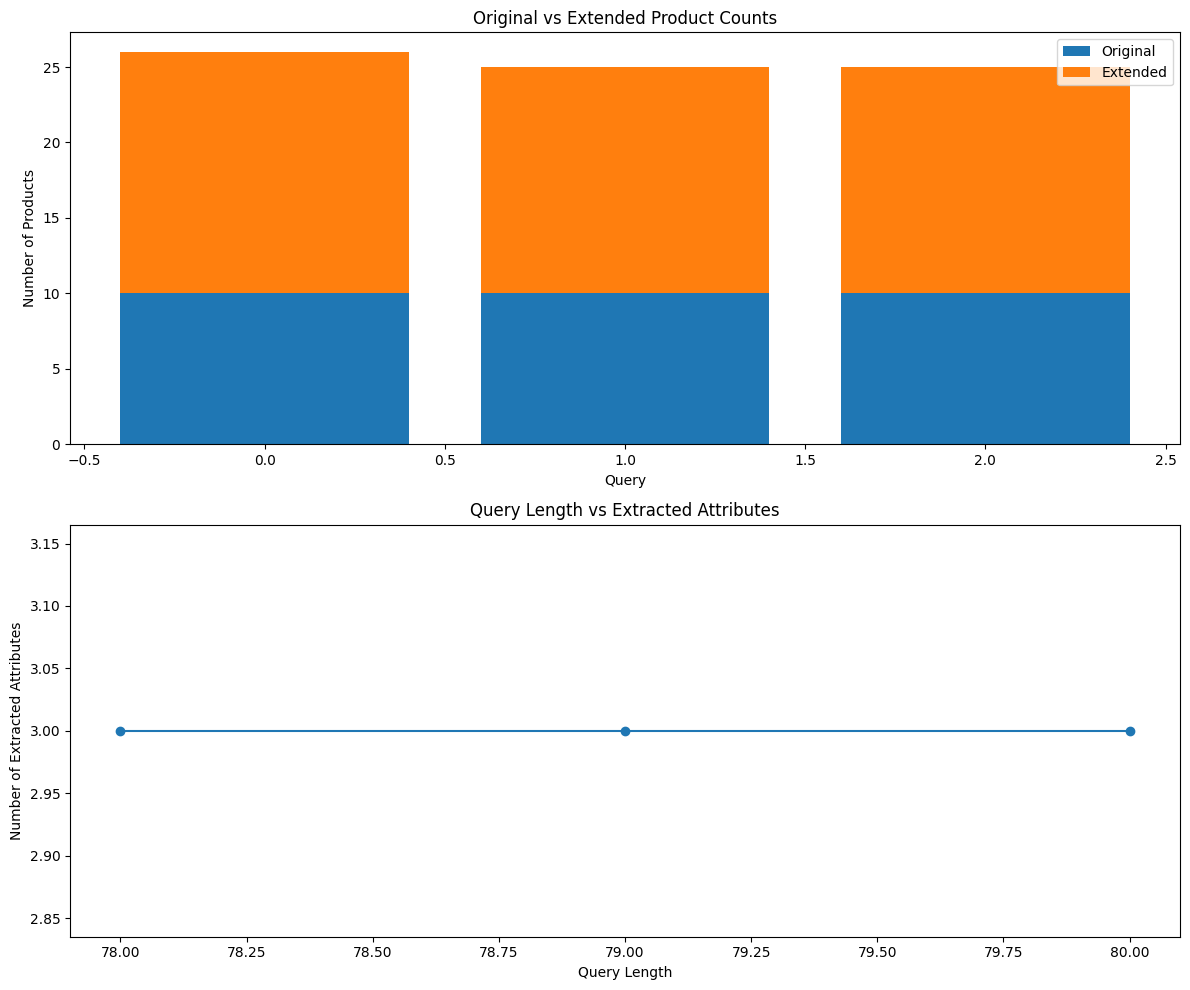

In [9]:
# Visualization
def visualize_experiments(experiments):
    query_lengths = [len(exp.query) for exp in experiments]
    original_counts = [len(exp.results["unique_original"]) for exp in experiments]
    extended_counts = [len(exp.results["unique_extended"]) for exp in experiments]
    attr_counts = [len(exp.results["comprehensive"]["extracted_attributes"]) for exp in experiments]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    ax1.bar(range(len(experiments)), original_counts, label="Original")
    ax1.bar(range(len(experiments)), extended_counts, bottom=original_counts, label="Extended")
    ax1.set_xlabel("Query")
    ax1.set_ylabel("Number of Products")
    ax1.set_title("Original vs Extended Product Counts")
    ax1.legend()

    ax2.plot(query_lengths, attr_counts, "o-")
    ax2.set_xlabel("Query Length")
    ax2.set_ylabel("Number of Extracted Attributes")
    ax2.set_title("Query Length vs Extracted Attributes")

    plt.tight_layout()
    plt.show()


# Run visualization
visualize_experiments(experiments)